<a href="https://colab.research.google.com/github/predicthq/phq-data-science-docs/blob/master/severe-weather-events/part_1_data_engineering.ipynb" target="_blank"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#### Venues-Example DATA SCIENCE GUIDES

# Venues Example

**A How To Guide to extracting venue information from PredictHQ's Attended Events data (conferences, expos, concerts, festivals, performing-arts, sports, community).**

    
The aim of this notebook is showcase how the PHQ Events API could be used to extract venue information for a location and time of your choice and basic map visuals.

- [Setup](#setup)
- [Access Token](#access_token)
- [SDK Parameters](#setting_params) 
- [Calling the PredictHQ API and Fetching Events](#calling_api)
- [Exploring the Result DataFrame and extract venue data](#exploring_df)
- [Displaying all venues on a map](#display_venue_loc)
- [What type of events are more frequently held in these venues?](#venue_most_freq_type)
- [What's the estimated capacity of venues?](#venue_est_capacity)
- [Appendix 1 - Finding place_id](#appendix-1)

<a id='setup'></a>
# Setup


- If you're using Google Colab, uncomment and run the following code block.

In [1]:
# %%capture
# !git clone https://github.com/predicthq/phq-data-science-docs.git
# %cd phq-data-science-docs/severe-weather-events
# !pip install pandas==1.1.5 predicthq==1.10.0 shapely==1.8.0 timezonefinder==5.2.0 


- Alternatively if you're running this notebook on a local machine, set up a Python environment using [requirements.txt](https://github.com/predicthq/phq-data-science-docs/blob/master/severe-weather-events/requirements.txt) file which is shared alongside the notebook.
These requirements can be installed by runing the command `pip install -r requirements.txt`.


In [2]:
from predicthq import Client
import requests
from timezonefinder import TimezoneFinder
import pandas as pd
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import plotly.express as px

# To display more columns and with a larger width in the DataFrame
pd.set_option("display.max_columns", 50)
pd.options.display.max_colwidth = 100

<a id='access_token'></a>
# Access Token
An Access Token is required to query the API. You can checked out our [API Quickstart](../../guides/quickstart/) page if you want to create an account or an access token.


In [3]:
ACCESS_TOKEN = 'REPLACE_WITH_ACCESS_TOKEN'
phq = Client(access_token=ACCESS_TOKEN)

<a id='setting_params'></a>
# SDK Parameters
To search for Severe-Weather Events, start by building a parameter dictionary and adding the required filters.

In [4]:
parameters = dict()

#### Location
Severe-weather events are specific to the location that they impact. We use polygons to show the geographic area impacted by the event. Polygons are used in our backend to filter events and return events that impact the selected location when you call our Events' API to get Severe-Weather Events. 

The location parameter could be set in one of the following ways:  

  1) Using the ```within``` parameter, which contains ```latitude```, ```longitude``` of the location with a ```radius```, and a ```unit``` for the radius. This would return events whose polygon intersects with the radius specified. Please note that using ```within``` would return more accurate results than ```place_id``` but bear in mind that ```radius``` should have an integer value greater than 0 (eg: `1m`). The result is relatively insensitive to the setting of radius as Severe-Weather Events have large location scopes. We recommend a radius of `1m` if you want to filter where the events polygon overrlaps the latitude and longitude of your location.
  
  2) Using a list of place_ids, returns events which have a geo-scoped ```place_id``` matching the given ```place_id``` or that intersects it's polygon. For example if you specify the place id for Seattle you will get events whose polygons overlap with the metropolitan area of Seattle.
   
Note: This notebook uses the state of ```Chicago``` as an example location. You can modify this to suit your location(s) of interest.

In [5]:
# Using latitude, longitude and a radius
latitude, longitude = (41.881832, -87.623177) # LAT, LONG for Chicago
radius = 5
radius_unit = "km"

within = f"{radius}{radius_unit}@{latitude},{longitude}"

Alternatively, we could have used a list of ```place_id``` for our search (See our Appendix on Place IDs for detailed explanation).

You can use either ```within``` or place_id as a filter but you can not use both.

In [6]:
parameters.update(within=within)  # Comment if you want to use place_ids
# parameters.update(place__scope=place_ids)  # Comment if you want to use lat and long

#### Date "YYYY-MM-DD"

To define the period of time for which Severe-Weather Events will be returned, set the greater than or equal (active.gte) and less than or equal (active.lte) parameters. This will select all Severe-Weather Events that are active within this period.

You could also use either of these parameters depending on your time period of interest:

```gte - Greater than or equal.``` <br>
```gt - Greater than.```<br>
```lte - Less than or equal.```<br>
```lt - Less than.```<br>


The default example in this notebook is to search for the whole of 2020.

In [7]:
start_time = "2021-01-01"
end_time = "2021-12-31"
parameters.update(active__gte=start_time)
parameters.update(active__lte=end_time)

#### Timezone 
By setting the timezone for the location of interest, the appropriate events will be returned.(<a href="https://en.wikipedia.org/wiki/List_of_tz_database_time_zones">tz database</a>)

For our New York example, the timezone would be ```America/New_York```. 
Use the `TimezoneFinder()` to find it for our location of interest.

In [8]:
timezone = TimezoneFinder().timezone_at(lat=latitude, lng=longitude)
print(timezone)

America/Chicago


In [9]:
parameters.update(active__tz=timezone)

#### Rank range

Similar to the date period, the rank range can be set to filter events. The rank_type can be set to either `rank`, `local_rank` or `aviation_rank`. The `rank` reflects the [estimated impact of an event](https://docs.predicthq.com/start/ranks/). The `local_rank` reflects the [estimated impact of an event in their local area](https://docs.predicthq.com/start/ranks/) by considering population density. Local Rank is useful when comparing events from multiple locations. The `aviation_rank` reflects the number of passengers who attend the event by flight. As a rule of thumb, here is the estimation of the number of attendance/passengers for typical rank_type and rank_threshold settings:

rank_type |rank_threshold |Number of attendance/passengers
:-----:|:-----:|:-----:
rank|$20$|$\sim30$
rank|$30$|$\sim100$
rank|$40$|$\sim300$
rank|$50$|$\sim1000$
rank|$60$|$\sim3000$
aviation_rank|$30$|$\sim20$
aviation_rank|$40$|$\sim40$
aviation_rank|$50$|$\sim100$
aviation_rank|$60$|$\sim200$

In [10]:
# Select events according to rank_type, rank threshold.
rank_type = "rank" # Set to be either "rank", "local_rank" or "aviation_rank".
rank_threshold = 40 
filter_parameter = "gte"
parameters.update({f"{rank_type}__{filter_parameter}": rank_threshold})

#### Categories
Set the category to `attendance category`.


In [11]:
categories = [
    "conferences",
    "expos",
    "concerts",
    "festivals",
    "performing-arts",
    "sports",
    "community",
]
parameters.update(category=categories)

#### Checking the parameters
Finally, let's take a look at the parameters we have set for our search.

In [12]:
parameters

{'within': '5km@41.881832,-87.623177',
 'active__gte': '2021-01-01',
 'active__lte': '2021-12-31',
 'active__tz': 'America/Chicago',
 'rank__gte': 40,
 'category': ['conferences',
  'expos',
  'concerts',
  'festivals',
  'performing-arts',
  'sports',
  'community']}

You can check out the full list of available parameters that you could use in querying Severe-Weather Events at our [Events Resource page](../../resources/events/).

#### Limits 
When pulling historical data for a large time period, many results are returned. To speed up the execution, set limit to the highest available setting (500). By doing this, each call to the API returns 500 results and this will generally speed up the time to retrieve large datasets.

In [13]:
parameters.update(limit=500)

#### Checking the parameters
Finally, let's take a look at the parameters we have set for our search.

In [14]:
parameters

{'within': '5km@41.881832,-87.623177',
 'active__gte': '2021-01-01',
 'active__lte': '2021-12-31',
 'active__tz': 'America/Chicago',
 'rank__gte': 40,
 'category': ['conferences',
  'expos',
  'concerts',
  'festivals',
  'performing-arts',
  'sports',
  'community'],
 'limit': 500}

<a id='calling_api'></a>
# Calling the PredictHQ API and Fetching Events

In this step, we use PHQ's Python SDK Client to query and fetch events using the parameters we defined above.

In [16]:
results = []

# Iterating through all the events that match our criteria and adding them to our results
for event in phq.events.search(parameters).iter_all():
    results.append(event.to_dict())

# Converting the results to a DataFrame
event_df = pd.DataFrame(results)

<a id='exploring_df'></a>
# Exploring the Result DataFrame and extract venue data
We take a look at the result data and extract venue information for our use case.

In [17]:
event_df.entities[0][0]

{'entity_id': 'xLVCdVzxtmahfdDMPEDXZB',
 'name': 'City Winery',
 'type': 'venue',
 'formatted_address': '1200 West Randolph Street\nChicago, IL 60607\nUnited States of America'}

In [18]:
event_df['lat'] = event_df.location.apply(lambda x: x[1])
event_df['lon'] = event_df.location.apply(lambda x: x[0])

# Extract entity information: id, name and type
event_df['entity_id'] = event_df.entities.apply(lambda x: x[0]['entity_id'] if len(x)>=1 else None)
event_df['entity_name'] = event_df.entities.apply(lambda x: x[0]['name'] if len(x)>=1 else None)
event_df['entity_type'] = event_df.entities.apply(lambda x: x[0]['type'] if len(x)>=1 else None)

<a id='display_venue_loc'></a>
# Displaying all venues on a map

In [19]:
# Specify the entity as venue and remove duplicate records
entity_loc = event_df[['lat','lon','entity_id','entity_name','entity_type']][event_df.entity_type=='venue'].drop_duplicates()
entity_loc

lat        lon                entity_id  \
0     41.884637 -87.657052   xLVCdVzxtmahfdDMPEDXZB   
1     41.885480 -87.627572   UniKDgC373FLJBdMmghKZc   
2     41.853878 -87.626753  3AqCHbCHCKhLNSJsVeRijxk   
3     41.910098 -87.652182   YhUBPfQsr43bjc6ADDqjwF   
4     41.888233 -87.629130   AfJwpDskcMhXWJWRjtALNV   
...         ...        ...                      ...   
1003  41.876452 -87.624869  33AY8zr5TjqT8yeHVmJucuR   
1047  41.875210 -87.658001   QJjfX3mJEReLU4USjyzyKc   
1113  41.849998 -87.650002   y8UT486CTjp4B6UhbGqxaL   
1127  41.914127 -87.628799   dCcKAP7DqkXXJuKDRvvwMu   
1137  41.891056 -87.625219   tSraYrXZpMBEZVcKwec8M7   

                                       entity_name entity_type  
0                                      City Winery       venue  
1                              The Chicago Theatre       venue  
2                               Reggie's Rock Club       venue  
3                                        Joe's Bar       venue  
4                           House of Blues Chicago       venue  
...                                            ...         ...  
1003                            Fine Arts Building       venue  
1047             University Of Illinois At Chicago       venue  
1113                            Windy City Ribfest       venue  
1127                     Lincoln Park South Fields       venue  
1137  The Gwen, a Luxury Collection Hotel, Chicago       venue  

[88 rows x 5 columns]

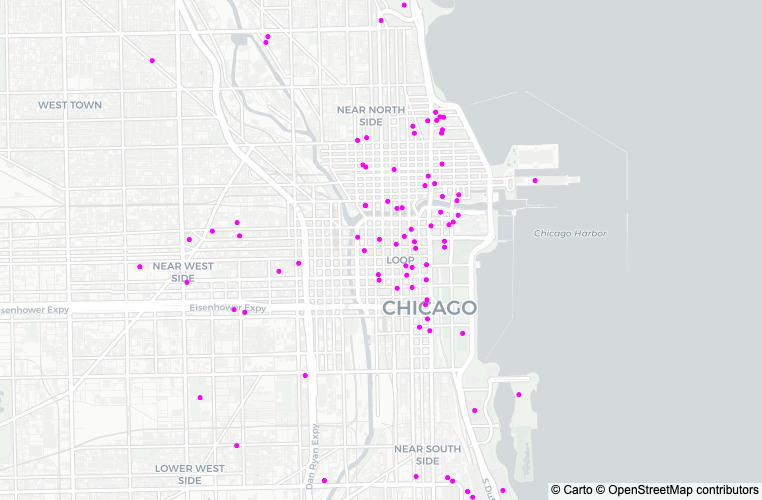

In [20]:
fig = px.scatter_mapbox(entity_loc, lat="lat", lon="lon",
                        hover_name="entity_name",  color_discrete_sequence=["fuchsia"],    
                        zoom=12)

fig.update_layout(mapbox_style="carto-positron")
fig.update_layout(height=500, margin={"r":0,"t":0,"l":0,"b":0})
fig.show()

<a id='venue_most_freq_type'></a>
# What type of events are more frequently held in these venues?

The map shows the type of events that happened most frequently for the venue in the past year which is distinguished by colours. The bigger size of circles means there were more events that happened.

In [21]:
agg_df = event_df[event_df.entity_type=='venue'].groupby(['lat','lon','entity_name','category']).agg({'entity_id':'count','phq_attendance':'max'}).reset_index()
venue_type = agg_df.loc[agg_df.reset_index().groupby(['entity_name'])['entity_id'].idxmax()]
venue_type.head()

lat        lon         entity_name         category  entity_id  \
20   41.863956 -87.663828  Addams/Medill Park        festivals          1   
6    41.852094 -87.611850  Arie Crown Theater  performing-arts          5   
32   41.875824 -87.625113  Auditorium Theatre         concerts         10   
67   41.885240 -87.661725       Bottom Lounge         concerts         10   
108  41.898190 -87.622225  Broadway Playhouse  performing-arts          4   

     phq_attendance  
20            64000  
6              2561  
32             3875  
67              350  
108             331

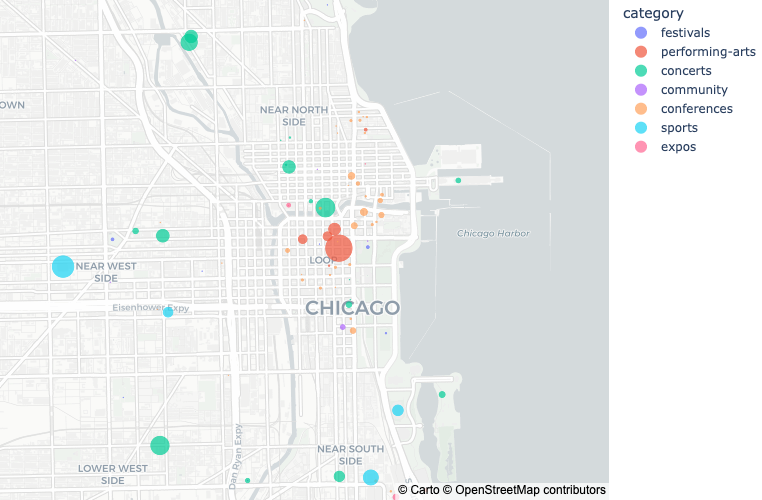

In [22]:
fig = px.scatter_mapbox(venue_type, lat="lat", lon="lon", color="category", size='entity_id',#"phq_attendance",
                        hover_name="entity_name", hover_data=['phq_attendance'],      
                        zoom=12)

fig.update_layout(mapbox_style="carto-positron")
fig.update_layout(height=500, margin={"r":0,"t":0,"l":0,"b":0})
fig.show()

<a id='venue_est_capacity'></a>
# What's the estimated capacity of venues?

The capacity is estimated based on the maximum of attendance for the time being.

In [23]:
venue_capacity = agg_df.loc[agg_df.reset_index().groupby(['phq_attendance'])['entity_id'].idxmax()]
venue_capacity

lat        lon                                  entity_name  \
66   41.884637 -87.657052                                  City Winery   
103  41.896840 -87.636805                           Parliament Chicago   
108  41.898190 -87.622225                           Broadway Playhouse   
36   41.878045 -87.627434  DePaul University Loop Campus DePaul Center   
67   41.885240 -87.661725                                Bottom Lounge   
..         ...        ...                                          ...   
77   41.886330 -87.657478                          Revel Fulton Market   
20   41.863956 -87.663828                           Addams/Medill Park   
3    41.851219 -87.617028                              McCormick Place   
23   41.872172 -87.618750                                   Grant Park   
57   41.883569 -87.630161                                  Daley Plaza   

            category  entity_id  phq_attendance  
66          concerts         38             300  
103         concerts          1             320  
108  performing-arts          4             331  
36       conferences          1             343  
67          concerts         10             350  
..               ...        ...             ...  
77         festivals          1           63500  
20         festivals          1           64000  
3              expos         11           90000  
23         festivals          2          385000  
57         festivals          1         1000000  

[76 rows x 6 columns]

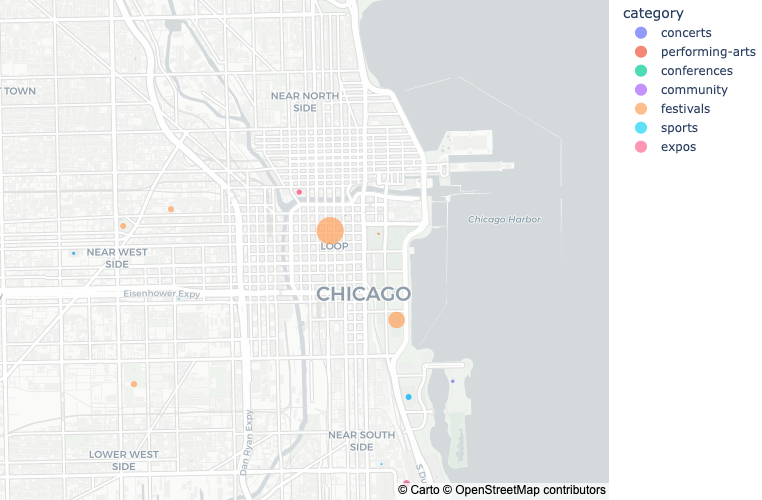

In [24]:
fig = px.scatter_mapbox(venue_capacity, lat="lat", lon="lon", color="category", size="phq_attendance",
                        hover_name="entity_name",
                        zoom=12)

fig.update_layout(mapbox_style="carto-positron")
fig.update_layout(height=500, margin={"r":0,"t":0,"l":0,"b":0})
fig.show()

<a id='appendix'></a>
## Appendix: Finding `place_id` 

Here is a guide on how to link between store locations and `place_id`. We present 3 options:

 1. Query `place_id` based on location name. Here the location name could be a city, a state, a country or a continent.
 2. Query `place_hierarchies` based on latitude and longitude.
 3. Query location name based on `place_id`.

The full list of parameters that you could use in your query is documented at our [Places API page](https://docs.predicthq.com/resources/places/).<br>PredictHQ uses the [geonames places](https://www.geonames.org/) convention. 

#### 1) Query `place_id` based on location name

By using PredictHQ's Places API, you can find the `place_id` for a specific location name. By calling the API and setting `q` to location name, the API will return the most relevant `place_id`. Taking the top `place_id` will provide the most relevant `place_id` the location name is in.

In [25]:
# Example location names.
locations = ["Chicago", "Cook County", "United States", "North America"]

place_id_lookup = pd.DataFrame()

for location in locations:
    response = requests.get(
        url="https://api.predicthq.com/v1/places/",
        headers={
            "Authorization": f"Bearer {ACCESS_TOKEN}",
            "Accept": "application/json",
        },
        params={"q": location},
    )

    data = response.json()
    df = pd.json_normalize(data["results"])
    place_id_lookup = place_id_lookup.append(df.iloc[0], ignore_index=True)

In [26]:
place_id_lookup[["id", "name", "type"]]

id           name       type
0  4887398        Chicago   locality
1  4888671    Cook County     county
2  6252001  United States    country
3  6255149  North America  continent

#### 2) Query `place_hierarchies` based on  latitude and longitude

By using PredictHQ's Places Hierarchies endpoint in the Place API, you can find the `place_hierarchies` for a specific latitude and longitude. By calling the API and setting `location.origin` to `latitude,longitude`, the API will return the most relevant `place_hierarchies`.

In [27]:
# Example locations.
latitude_longitudes = [[41.881832, -87.623177]]

place_hierarchies_lookup = pd.DataFrame()

for latitude_longitude in latitude_longitudes:
    latitude, longitude = latitude_longitude
    response = requests.get(
        url="https://api.predicthq.com/v1/places/hierarchies",
        headers={
            "Authorization": f"Bearer {ACCESS_TOKEN}",
            "Accept": "application/json",
        },
        params={"location.origin": f"{latitude},{longitude}"},
    )

    data = response.json()
    df = pd.DataFrame(data)
    df["latitude"] = latitude
    df["longitude"] = longitude
    place_hierarchies_lookup = place_hierarchies_lookup.append(df, ignore_index=True)

In [28]:
place_hierarchies_lookup

place_hierarchies  \
0  [{'place_id': '6295630', 'type': 'planet'}, {'place_id': '6255149', 'type': 'continent'}, {'plac...   

    latitude  longitude  
0  41.881832 -87.623177

For each `latitude,longitude`, the response might include more than one hierarchy. The reason for this is we try to match the closest place's hierarchy but we also include the closest major city's hierarchy within a radius of 50km. This only applies if the level is below region and, if it exists, the major city's hierarchy will always be the second row of the DataFrame.

#### 3) Query location name based on `place_id`

By using PredictHQ's Places API, you can find the location name for a specific `place_id`. By calling the API and setting `id` to `place_id`, the API will return the most relevant location name. Taking the top location name will provide the most relevant location name the `place_id` is in.

In [29]:
# Example place_ids.
place_ids = ["6295630", "6255149", "6252001", "4896861", "4888671", "4887398"]

location_lookup = pd.DataFrame()

for place_id in place_ids:
    response = requests.get(
        url="https://api.predicthq.com/v1/places/",
        headers={
            "Authorization": f"Bearer {ACCESS_TOKEN}",
            "Accept": "application/json",
        },
        # The id could be a comma-separated list of place_ids. In this example, the
        # events are queried based on each place_id.
        params={"id": place_id},
    )

    data = response.json()
    df = pd.json_normalize(data["results"])
    location_lookup = location_lookup.append(df.iloc[0], ignore_index=True)

In [30]:
location_lookup[["id", "name", "type"]]

id           name       type
0  6295630          Earth     planet
1  6255149  North America  continent
2  6252001  United States    country
3  4896861       Illinois     region
4  4888671    Cook County     county
5  4887398        Chicago   locality